In [7]:
from torch.xpu import device
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image

device = 'mps'

processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-handwritten').to(device)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.2"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 1024,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decod

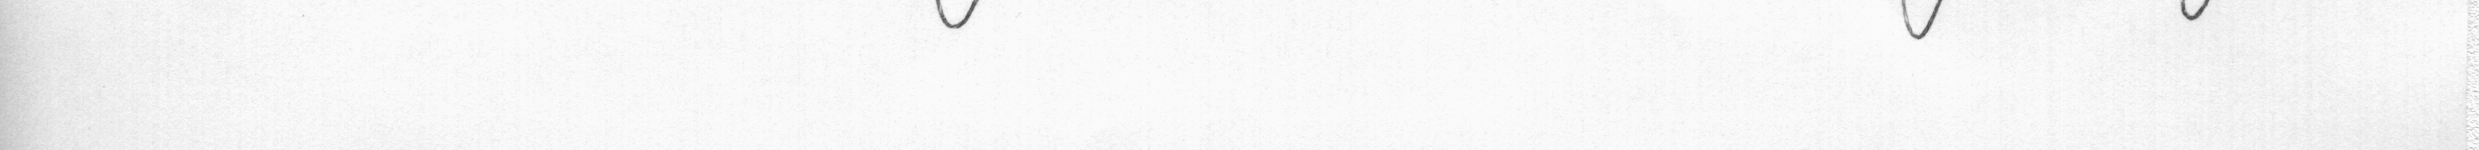

In [135]:
filepath = 'data/iam_form2.png'
image = Image.open(filepath).convert("RGB")

cropped_images = []
y = []
for i in range(700, image.height - 850, 50):
    height  = 150
    cropped_image = image.crop((0, i, image.width, i + height))
    cropped_images.append(cropped_image)
    y.append(i)

cropped_images[-1]

In [47]:
model.config.num_beams = 2

In [136]:
pixel_values = processor(images=cropped_images, return_tensors="pt").pixel_values.to(device)
output = model.generate(pixel_values, return_dict_in_generate=True, output_scores=True)
generated_ids, scores = output.sequences, output.sequences_scores
scores

/Users/amaljoe/Desktop/Workspace/IITB/NLP/OCR_with_LLMs/.venv/lib/python3.9/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


tensor([-0.6494, -0.7132, -0.2481, -0.0760, -0.0942, -1.0560, -0.2040, -0.0495,
        -0.2273, -0.4999, -0.3375, -0.0716, -0.7936, -0.0482, -0.0164, -0.4829,
        -0.5272, -0.1499, -0.0129, -0.7041, -0.5084, -0.0077, -0.0233, -1.2843,
        -0.2046, -0.1234, -0.2455, -0.5804, -0.1357, -0.0493, -1.8295, -0.4146,
        -0.1565, -0.3837, -0.5954, -0.0670, -0.1138, -0.8240, -1.5804, -1.7719],
       device='mps:0')

In [137]:
generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)
print(generated_texts)

['0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0', 'Download as PDFPrintable version', '# But he said discussions " on a higher', 'But he said discussions " on a higher', 'But he said discussions " on a higher', 'HelpLearn to remove the minimum manner .', 'level than in the past " might be " useful .', 'level than in the past " might be useful .', 'never than it the past might be useful .', 'The President , still probably discuss the', 'the President will probably discuss the', 'the President will probably discuss the', 'the musicians since pursuing business rule .', 'children with Dr. Brentano , the West', 'problem with Dr. Brentano , the West', 'problem with Dr. Svencove , the West', 'American Russian Minister of India is also a', 'German Foreign Minister , who is due in', 'German Foreign Minister , who is due in', 'women foreign ministers , who is due to', 'Washington next week . A basilico of', 'Washington next week . A big slice of', 'Washington next week . A big slice of', 'Not logged in'

<Axes: >

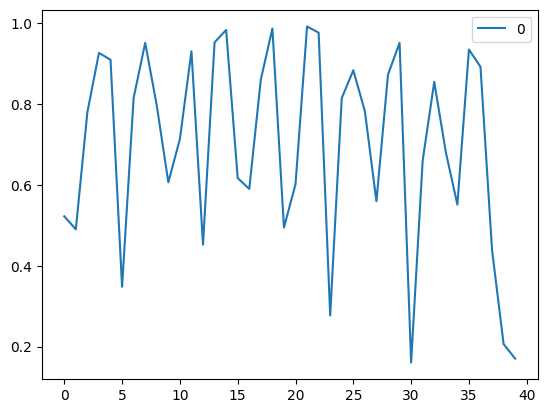

In [162]:
import pandas as pd
import numpy as np

scores_df = pd.DataFrame(np.exp(scores.to('cpu').numpy()))

scores_df.plot()

In [152]:
import numpy as np

normalised_scores = np.exp(scores.to('cpu').numpy())

In [153]:
qualified_texts = []

for text, score, y_i in zip(generated_texts, normalised_scores, y):
    if score > 0.8:
        print(f"Text: {text}, Score: {score}")

        qualified_texts.append({
            'text': text,
            'score': score,
            'y': y_i
        })

Text: But he said discussions " on a higher, Score: 0.9268220067024231
Text: But he said discussions " on a higher, Score: 0.9101097583770752
Text: level than in the past " might be " useful ., Score: 0.8154563307762146
Text: level than in the past " might be useful ., Score: 0.9517272710800171
Text: the President will probably discuss the, Score: 0.9309306144714355
Text: children with Dr. Brentano , the West, Score: 0.9529202580451965
Text: problem with Dr. Brentano , the West, Score: 0.9836893081665039
Text: German Foreign Minister , who is due in, Score: 0.8607829809188843
Text: German Foreign Minister , who is due in, Score: 0.9871903657913208
Text: Washington next week . A big slice of, Score: 0.9923123717308044
Text: Washington next week . A big slice of, Score: 0.9770097136497498
Text: Germany's " aid " is the early payment ., Score: 0.8149911165237427
Text: Germany's " aid " is the early payment ., Score: 0.8838740587234497
Text: of a 210million debt to America . United, Score:

In [154]:
from nltk.translate import bleu_score
from nltk.translate.bleu_score import SmoothingFunction

final_texts = []

def get_bleu_score(hypothesis, references):
    weights = [0.5, 0.5]
    smoothing = SmoothingFunction()
    return bleu_score.sentence_bleu(references, hypothesis, weights=weights, smoothing_function=smoothing.method1)

for i in range(len(qualified_texts)):
    hyp = qualified_texts[i]['text'].split()
    bleu = 0
    if i < len(qualified_texts) - 1:
        ref = qualified_texts[i + 1]['text'].split()
        bleu = get_bleu_score(hyp, [ref])
    qualified_texts[i]['bleu'] = bleu
    
qualified_texts_df = pd.DataFrame(qualified_texts)
qualified_texts_df

,text,score,y,bleu
0,"But he said discussions "" on a higher",0.926822,850,1.000000
1,"But he said discussions "" on a higher",0.910110,900,0.029043
2,"level than in the past "" might be "" useful .",0.815456,1000,0.852803
3,"level than in the past "" might be useful .",0.951727,1050,0.033333
4,the President will probably discuss the,0.930931,1250,0.048872
5,"children with Dr. Brentano , the West",0.952920,1350,0.845154
6,"problem with Dr. Brentano , the West",0.983689,1400,0.042299
7,"German Foreign Minister , who is due in",0.860783,1550,1.000000
8,"German Foreign Minister , who is due in",0.987190,1600,0.000000
9,Washington next week . A big slice of,0.992312,1750,1.000000


<Axes: >

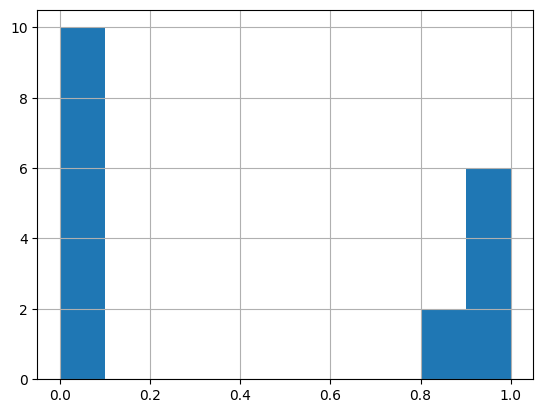

In [155]:
qualified_texts_df['bleu'].hist()

In [156]:
import numpy as np

final_texts = []

new = True
for i in range(len(qualified_texts)):
    if new:
        final_texts.append(qualified_texts[i])
    else:
        if final_texts[-1]['score'] < qualified_texts[i]['score']:
            final_texts[-1] = qualified_texts[i]
    new = qualified_texts[i]['bleu'] < 0.5
    
final_texts_df = pd.DataFrame(final_texts)
final_texts_df

,text,score,y,bleu
0,"But he said discussions "" on a higher",0.926822,850,1.000000
1,"level than in the past "" might be useful .",0.951727,1050,0.033333
2,the President will probably discuss the,0.930931,1250,0.048872
3,"problem with Dr. Brentano , the West",0.983689,1400,0.042299
4,"German Foreign Minister , who is due in",0.987190,1600,0.000000
5,Washington next week . A big slice of,0.992312,1750,1.000000
6,"Germany's "" aid "" is the early payment .",0.883874,1950,0.037268
7,of a 210million debt to America . United,0.951852,2150,0.000000
8,States officials quickly point out that,0.855144,2300,0.000000
9,this is money due to America anyway .,0.935205,2450,1.000000
